# Sampling example

The following notebook shows the sampling procedure after loading the trained model checkpoint. Running the next cell will download the model weights from dropbox.

In [ ]:
import requests

url = "https://www.dropbox.com/scl/fi/ryt0sy2z06xv4op51mv7b/cifar_fixed_model.pth?rlkey=1sxz3qokjyw64vnztjs6eehdw&st=i5iusa4b&dl=1"
output_file = "cifar_more_mid_layers/cifar_fixed_model.pth"

response = requests.get(url)
with open(output_file, "wb") as f:
    f.write(response.content)

print(f"File saved as {output_file}")


train_config['task_name']: cifar_more_mid_layers
train_config['ckpt_name']: cifar_fixed_model.pth
32
64
64
128
128
256


0it [00:00, ?it/s]

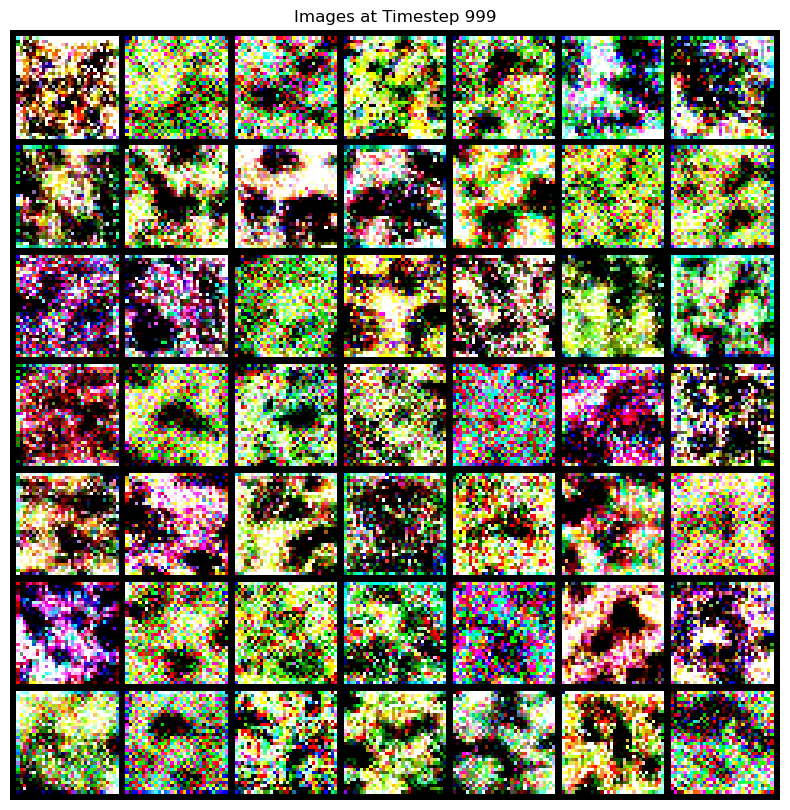

248it [00:24, 10.25it/s]

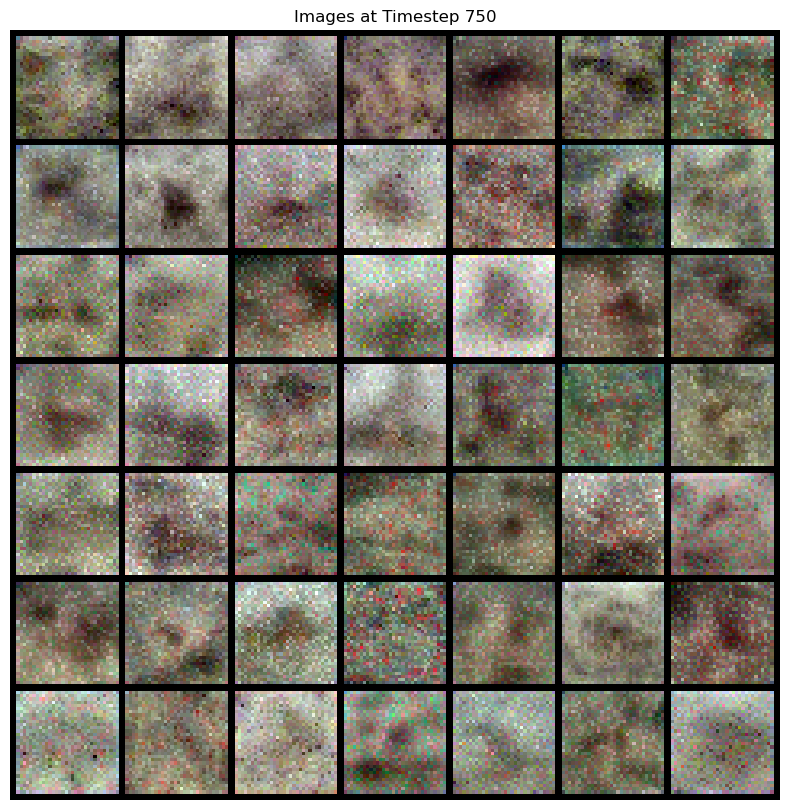

498it [00:49, 10.12it/s]

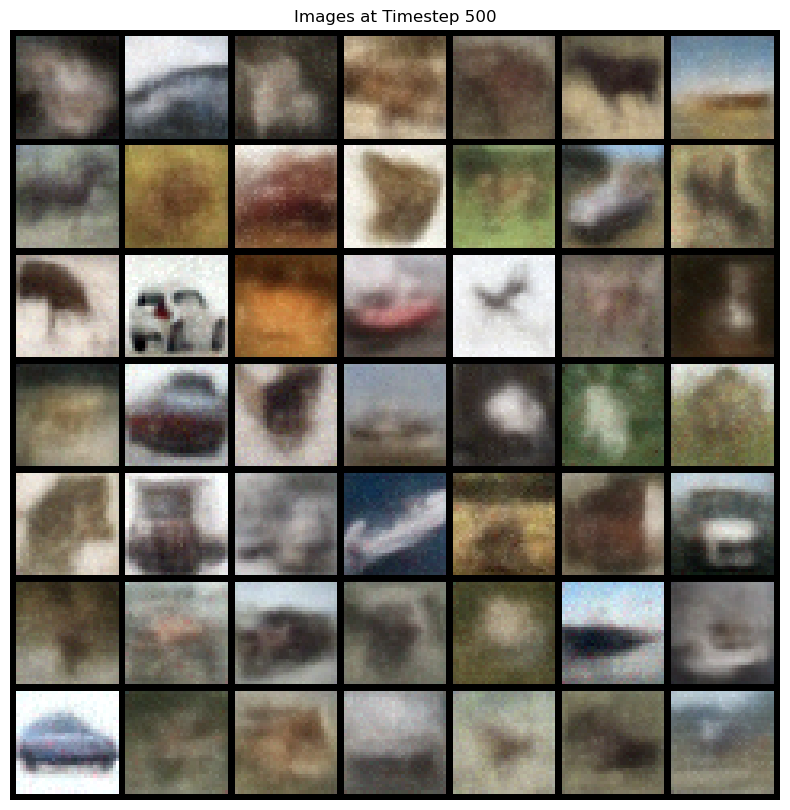

749it [01:14,  9.62it/s]

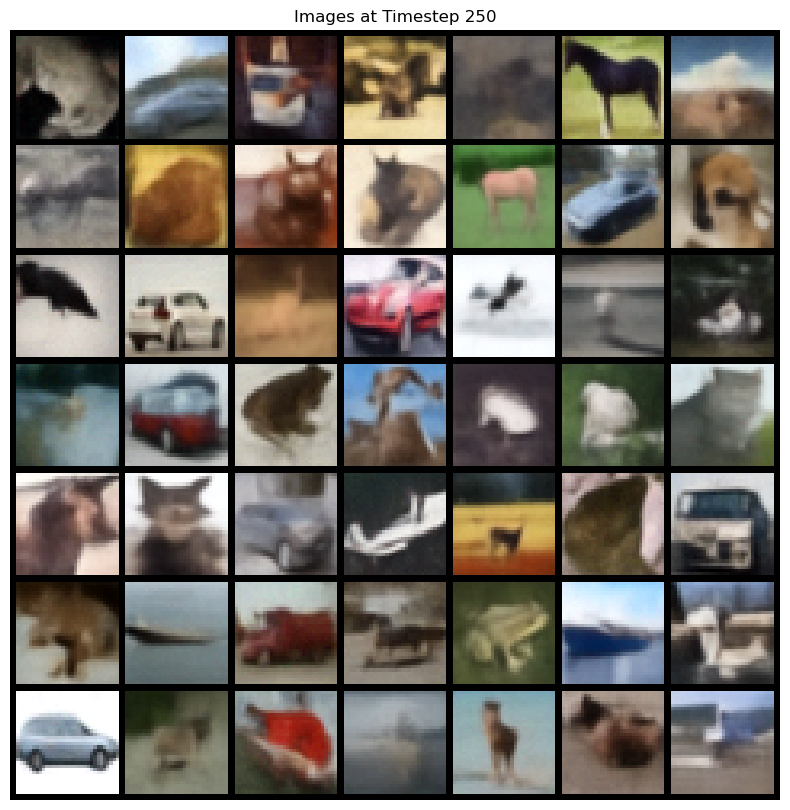

998it [01:40,  9.58it/s]

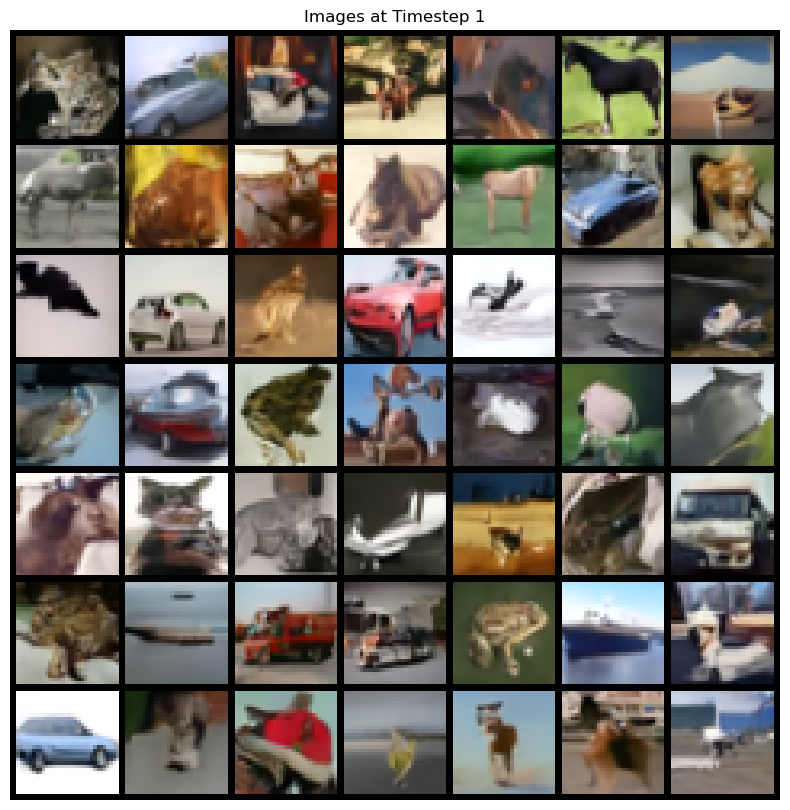

1000it [01:40,  9.91it/s]


In [1]:
import torch
import torchvision
import yaml
import os
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
from models.unet_base import Unet
from scheduler.linear_noise_scheduler import LinearNoiseScheduler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'  # Use CPU for sampling

def get_latest_index(output_dir):
    """
    Find the highest index of existing images in the output directory.
    """
    if not os.path.exists(output_dir):
        return 0

    png_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]
    if not png_files:
        return 0

    # Extract numerical indices from filenames
    indices = [int(f.split('_')[1].split('.')[0]) for f in png_files if '_' in f and f.split('_')[1].split('.')[0].isdigit()]
    return max(indices) + 1 if indices else 0

def display_grid(images, title="Grid of Images"):
    """
    Display a grid of images using Matplotlib.
    """
    grid = make_grid(images, nrow=7, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(title)
    plt.show()

def sample(model, scheduler, train_config, model_config, diffusion_config):
    r"""
    Sample stepwise by going backward one timestep at a time.
    Display grids of images at specified timesteps.
    """
    # Generate random noise as the starting point
    xt = torch.randn((49,
                      model_config['im_channels'],
                      model_config['im_size'],
                      model_config['im_size'])).to(device)

    # Create output directory for saving images
    output_dir = os.path.join(train_config['task_name'], train_config['folder_name'])
    os.makedirs(output_dir, exist_ok=True)

    # Get the latest index to continue sampling
    start_index = get_latest_index(output_dir)

    # Reverse diffusion process
    timesteps_to_display = [1, 250, 500, 750, diffusion_config['num_timesteps'] - 1]
    for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
        # Predict noise for timestep `i`
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))

        # Use scheduler to get x_t-1 and x_0
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))

        # Display images at specified timesteps
        if i in timesteps_to_display:
            display_grid(x0_pred, title=f"Images at Timestep {i}")

    # Save the final denoised images (at t=0)
    # ims = torch.clamp(x0_pred, -1., 1.).detach().cpu()  # Rescale values to [0, 1]
    # ims = (ims + 1) / 2  # Normalize to [0, 1] for saving
    # for idx, img in enumerate(ims):
    #     img_pil = torchvision.transforms.ToPILImage()(img)
    #     img_pil.save(os.path.join(output_dir, f"sample_{start_index + idx:05d}.png"))

def load_config(config_path):
    """
    Load configuration file.
    """
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
            raise
    return config

# Main execution
if __name__ == '__main__':
    # Set configuration path
    config_path = 'config/sampling.yaml'  # Update this path if necessary

    # Load configuration
    config = load_config(config_path)

    diffusion_config = config['diffusion_params']
    model_config = config['model_params']
    train_config = config['train_params']
    
    print("train_config['task_name']:", train_config['task_name'])
    print("train_config['ckpt_name']:", train_config['ckpt_name'])

    # Load model with checkpoint
    model = Unet(model_config).to(device)
    model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                  train_config['ckpt_name']),
                                     map_location=device))
    model.eval()

    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])

    # Sampling process
    with torch.no_grad():
        sample(model, scheduler, train_config, model_config, diffusion_config)
